In [127]:
import os
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import root_mean_squared_error as rmse

## Loading data

In [128]:
DATA_PATH = '/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated.csv'

# Adjust these column names as needed.
date_col = 'time'
target_col = 'KarupBro'
# List of meteorological features from DMI – update if needed.
input_cols = [
    'temp_min_daily', 'temp_max_daily', 'temp_mean_daily', 
    'temp_grass_mean_daily', 'temp_soil_min_daily', 'temp_soil_max_daily', 
    'temp_soil_mean_daily', 'humidity_daily', 'wind_direction_daily', 
    'wind_speed_daily', 'wind_gust_max_daily', 'precip_total_daily', 
    'precip_duration_daily', 'radiation_global_daily', 
    'sunshine_duration_daily'
]


# Read the CSV
df = pd.read_csv(DATA_PATH, parse_dates=[date_col])
df.sort_values(date_col, inplace=True)
df.reset_index(drop=True, inplace=True)

# Optional: Set the date column as index (if needed)
df.set_index(date_col, inplace=True)

df.tail()

,temp_min_daily,temp_max_daily,temp_mean_daily,temp_grass_mean_daily,temp_soil_min_daily,temp_soil_max_daily,temp_soil_mean_daily,humidity_daily,wind_direction_daily,wind_gust_max_daily,wind_speed_daily,precip_total_daily,precip_duration_daily,radiation_global_daily,sunshine_duration_daily,KarupBro
time,,,,,,,,,,,,,,,,
2023-12-20,0.8,4.4,3.141667,2.316667,5.1,5.4,5.241667,88.583333,252.000000,12.2,2.541667,0.4,4.0,349.0,111.0,4448.18
2023-12-21,1.4,8.7,5.316667,4.637500,5.0,5.3,5.141667,86.083333,254.666667,22.5,5.329167,19.9,159.0,270.0,29.5,5602.14
2023-12-22,0.1,4.0,2.395833,1.129167,4.0,5.1,4.533333,66.000000,293.416667,19.1,5.020833,0.6,3.0,749.0,294.5,6636.60
2023-12-23,-1.6,3.3,0.833333,-0.250000,3.6,4.1,3.754167,88.000000,264.000000,10.5,2.379167,0.8,4.0,589.0,247.0,5809.15
2023-12-24,-0.3,2.1,1.120000,0.700000,3.4,3.6,3.520000,97.700000,136.500000,6.6,1.500000,5.0,38.0,9.0,0.0,5197.78


In [129]:
# Check for missing values
df.isnull().sum()

temp_min_daily             0
temp_max_daily             0
temp_mean_daily            0
temp_grass_mean_daily      0
temp_soil_min_daily        0
temp_soil_max_daily        0
temp_soil_mean_daily       0
humidity_daily             0
wind_direction_daily       0
wind_gust_max_daily        0
wind_speed_daily           0
precip_total_daily         0
precip_duration_daily      0
radiation_global_daily     0
sunshine_duration_daily    0
KarupBro                   0
dtype: int64

<Figure size 1200x1200 with 0 Axes>

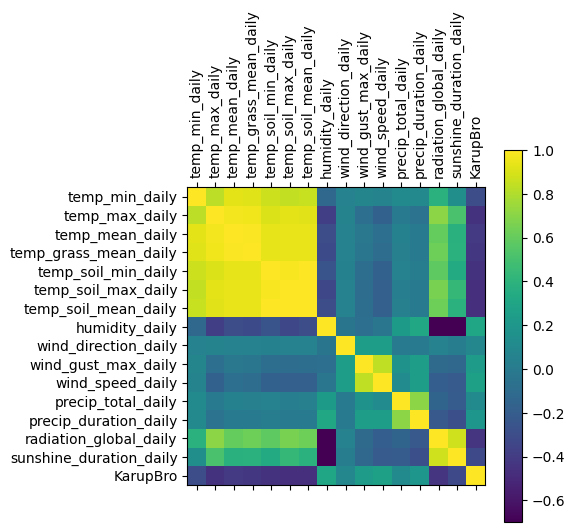

In [130]:
# Correlation matrix
corr = df.corr()
plt.figure(figsize=(12, 12))
plt.matshow(corr, fignum=2)
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.show()

## Filtering data to simple model

In [131]:
df_simple = df[["temp_mean_daily", "precip_total_daily", "KarupBro"]]
df_simple.head()

,temp_mean_daily,precip_total_daily,KarupBro
time,,,
2002-01-01,1.250000,2.2,1829.75
2002-01-02,-0.837500,0.0,7279.46
2002-01-03,-5.166667,0.0,5261.85
2002-01-04,-6.025000,0.0,2951.97
2002-01-05,-3.466667,0.1,1868.53


<Axes: xlabel='time'>

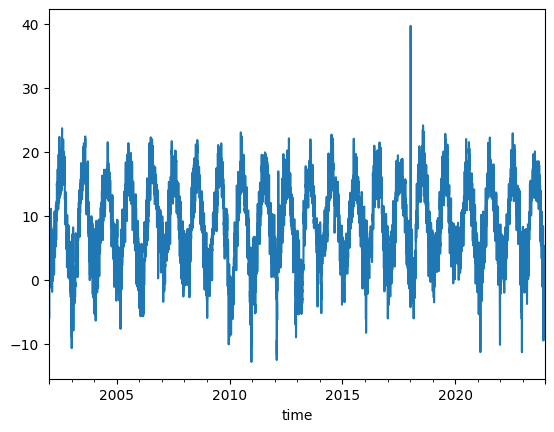

In [132]:
temp = df['temp_mean_daily']
temp.plot()

In [133]:
# Replace outliers with NaN
df.loc[df["temp_mean_daily"] > 35, "temp_mean_daily"] = np.nan

# Forward-fill (ffill) the missing values
df["temp_mean_daily"] = df["temp_mean_daily"].ffill()

<Axes: xlabel='time'>

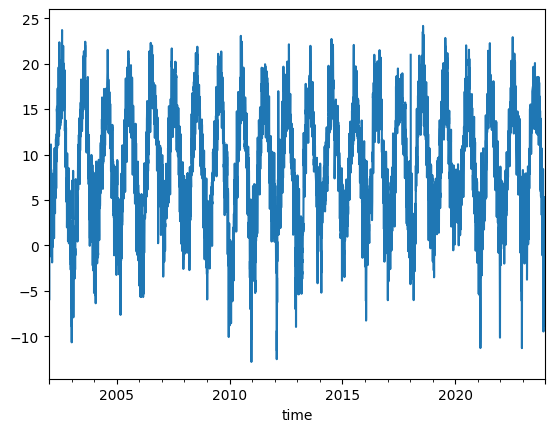

In [134]:
temp.plot()

<Axes: xlabel='time'>

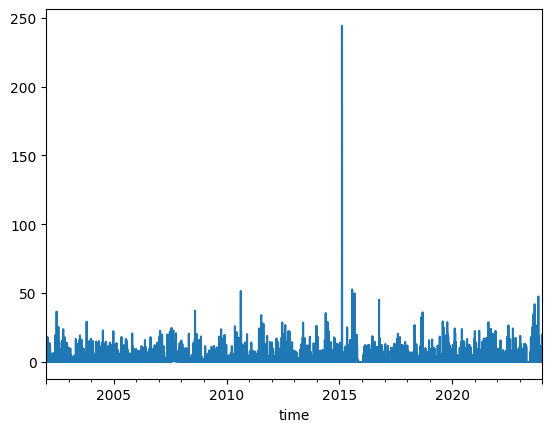

In [135]:
rain = df['precip_total_daily']
rain.plot()

In [136]:
import numpy as np

# Replace outliers with NaN
df.loc[df["precip_total_daily"] > 100, "precip_total_daily"] = np.nan

# Forward-fill (ffill) the missing values
df["precip_total_daily"] = df["precip_total_daily"].ffill()

<Axes: xlabel='time'>

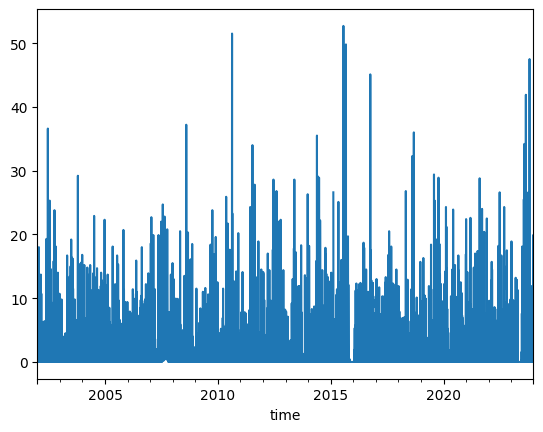

In [137]:
rain.plot()

<Axes: xlabel='time'>

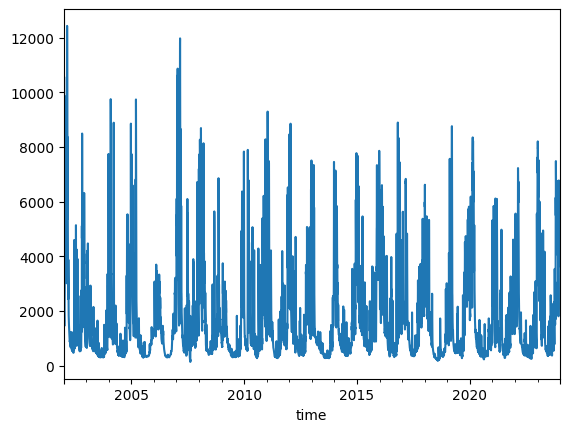

In [138]:
inflow = df['KarupBro']
inflow.plot()

## Multi-variable

In [139]:
inflow_df = pd.DataFrame({'Inflow':inflow})
inflow_df['Seconds'] = inflow_df.index.map(pd.Timestamp.timestamp)
inflow_df

,Inflow,Seconds
time,,
2002-01-01,1829.75,1.009843e+09
2002-01-02,7279.46,1.009930e+09
2002-01-03,5261.85,1.010016e+09
2002-01-04,2951.97,1.010102e+09
2002-01-05,1868.53,1.010189e+09
...,...,...
2023-12-20,4448.18,1.703030e+09
2023-12-21,5602.14,1.703117e+09
2023-12-22,6636.60,1.703203e+09


In [140]:
day = 24*60*60
year = (365.2425)*day

inflow_df['Rain'] = df['precip_total_daily']
inflow_df['Temp'] = df['temp_mean_daily']
# inflow_df['PET'] = df['ET0']
inflow_df['Year sin'] = np.sin(inflow_df['Seconds'] * (2 * np.pi / year))
inflow_df['Year cos'] = np.cos(inflow_df['Seconds'] * (2 * np.pi / year))
inflow_df = inflow_df.drop('Seconds', axis=1)
inflow_df

,Inflow,Rain,Temp,Year sin,Year cos
time,,,,,
2002-01-01,1829.75,2.2,1.250000,0.004129,0.999991
2002-01-02,7279.46,0.0,-0.837500,0.021330,0.999772
2002-01-03,5261.85,0.0,-5.166667,0.038525,0.999258
2002-01-04,2951.97,0.0,-6.025000,0.055708,0.998447
2002-01-05,1868.53,0.1,-3.466667,0.072875,0.997341
...,...,...,...,...,...
2023-12-20,4448.18,0.4,3.141667,-0.206570,0.978432
2023-12-21,5602.14,19.9,5.316667,-0.189708,0.981841
2023-12-22,6636.60,0.6,2.395833,-0.172790,0.984959


In [141]:
import numpy as np

HORIZON = 1
WINDOW = 5
EXOS = ['Rain', 'Temp', 'Year sin', 'Year cos']
# EXOS = ['Rain', 'Temp', 'PET' ,'Year sin', 'Year cos']

def df_to_X_y_multi_step_exo(df, window_size=WINDOW, horizon=HORIZON, 
                               inflow_col='Inflow', 
                               exo_cols=EXOS):
    """
    Prepares data for direct multi-step forecasting (k-step ahead) by:
      - Using the past 'window_size' days of data as historical input.
      - Including the exogenous features for the *next* 'horizon' days.
      - Predicting 'horizon' days of inflow in one shot.
    
    Parameters:
      df: DataFrame containing the data.
      window_size: Number of past days used as input.
      horizon: Forecast length (number of days ahead).
      inflow_col: Name of the target variable column.
      exo_cols: List of column names to use as exogenous features.
                If None, defaults to all columns except the target.
                
    Returns:
      X : np.array with shape (num_samples, window_size, num_features + len(exo_cols)*horizon)
          For each sample, the historical window is stored in the first 'num_features' columns,
          and the forecast exogenous data for the next 'horizon' days is appended to the last row.
      y : np.array with shape (num_samples, horizon)
          The target inflow values for the next 'horizon' days.
    """
    # If no exogenous columns provided, use all columns except the inflow
    if exo_cols is None:
        exo_cols = [col for col in df.columns if col != inflow_col]
    
    # Convert DataFrame to numpy array
    data = df.to_numpy()  # shape: (total_days, num_features)
    num_features = data.shape[1]
    
    # Determine the column indices for the inflow and exogenous features
    col_names = list(df.columns)
    inflow_idx = col_names.index(inflow_col)
    exo_indices = [col_names.index(col) for col in exo_cols]
    
    X, y = [], []
    n = len(data)
    
    # Loop over possible starting indices for the forecast window
    for i in range(n - window_size - horizon + 1):
        # 1) Historical window: take all features for the past 'window_size' days.
        hist_window = data[i : i + window_size, :]
        
        # 2) Future exogenous features: take the specified exo features for the next 'horizon' days.
        exo_future = data[i + window_size : i + window_size + horizon, :][:, exo_indices]
        
        # 3) Build a sample matrix: start with historical data and then append forecast exo features in the last row.
        sample = np.zeros((window_size, num_features + len(exo_cols) * horizon))
        sample[:, :num_features] = hist_window
        
        # Append each day's exogenous data into the extra columns of the last row.
        for day_idx in range(horizon):
            start_col = num_features + day_idx * len(exo_cols)
            end_col = start_col + len(exo_cols)
            sample[-1, start_col:end_col] = exo_future[day_idx]
        
        # 4) The label is the inflow for the next 'horizon' days.
        future_inflow = data[i + window_size : i + window_size + horizon, inflow_idx]
        
        X.append(sample)
        y.append(future_inflow)
    
    return np.array(X), np.array(y)

In [142]:
# X2, y2 = df_to_X_y2(inflow_df)
X, y = df_to_X_y_multi_step_exo(inflow_df)

X.shape, y.shape

((8023, 5, 9), (8023, 1))

In [143]:
X2_train, y2_train = X[:6000], y[:6000]
X2_val, y2_val = X[6000:7000], y[6000:7000]
X2_test, y2_test = X[7000:], y[7000:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((6000, 5, 9), (6000, 1), (1000, 5, 9), (1000, 1), (1023, 5, 9), (1023, 1))

### Preprocessing

In [144]:
# Compute the training statistics from the first channel (inflow) in X2_train
inflow_training_mean = np.mean(X2_train[:, :, 0])
inflow_training_std = np.std(X2_train[:, :, 0])

rain_training_mean = np.mean(X2_train[:, :, 1])
rain_training_std = np.std(X2_train[:, :, 1])

temp_training_mean = np.mean(X2_train[:, :, 2])
temp_training_std = np.std(X2_train[:, :, 2])

# PET_training_mean = np.mean(X2_train[:, :, 3])
# PET_training_std = np.std(X2_train[:, :, 3])

# Define the preprocessing functions for features and output
def preprocess(X):
    # Standardize the first three channels (features)
    X[:, :, 0] = (X[:, :, 0] - inflow_training_mean) / inflow_training_std 
    X[:, :, 1] = (X[:, :, 1] - rain_training_mean) / rain_training_std
    X[:, :, 2] = (X[:, :, 2] - temp_training_mean) / temp_training_std 
    # X[:, :, 3] = (X[:, :, 3] - PET_training_mean) / PET_training_std
    return X

def preprocess_output(y):
    # Standardize every element in y
    y[:] = (y[:] - inflow_training_mean) / inflow_training_std
    return y

# Apply preprocessing to all datasets
preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)
preprocess_output(y2_train)
preprocess_output(y2_val)
preprocess_output(y2_test)

array([[-0.38355823],
       [-0.44990893],
       [-0.47533252],
       ...,
       [ 3.00218845],
       [ 2.50380534],
       [ 2.13556981]])

In [145]:
y_train_mean = y2_train.mean(axis=0)  # shape (horizon,)
y_train_std  = y2_train.std(axis=0)   # shape (horizon,)

# Avoid division by zero
y_train_std[y_train_std == 0] = 1e-7

In [146]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense

# Your raw threshold for extreme inflow values
T_raw = 7000

# Convert the raw threshold to the scaled threshold
T_scaled = (T_raw - y_train_mean) / y_train_std

def weighted_mse_for_extremes(y_true, y_pred, threshold=T_scaled, alpha=2.0):
    """
    Custom loss function that penalizes errors on extreme values.
    
    Args:
      y_true, y_pred: tensors with shape (batch_size, horizon)
      threshold: threshold in the scaled space (computed from raw threshold)
      alpha: scaling factor for extra penalty.
      
    Returns:
      A scalar loss value.
    """
    # Base mean squared error
    base_mse = K.square(y_true - y_pred)
    
    # Extra weight for values above the scaled threshold
    weight = 1.0 + alpha * K.relu(y_true - threshold)
    
    # Compute weighted mse
    weighted_mse = weight * base_mse
    return K.mean(weighted_mse, axis=-1)

def my_extreme_loss(y_true, y_pred):
    return weighted_mse_for_extremes(y_true, y_pred)

In [147]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (InputLayer, LSTM, Dense, Layer, Input, 
                                     Flatten, Concatenate, GlobalAveragePooling1D,
                                     LayerNormalization, MultiHeadAttention)
import tensorflow.keras.backend as K
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError

# --------------------------
# Global parameters and data prep
# --------------------------
HORIZON = 1
WINDOW = 5
EXOS = ['Rain', 'Temp', 'Year sin', 'Year cos']
# The input shape for the models is based on your data engineering:
#   (WINDOW, (len(EXOS)+1) + len(EXOS)*HORIZON)
input_shape = (WINDOW, (len(EXOS) + 1) + len(EXOS) * HORIZON)

# --------------------------
# Custom attention layer (additive/Bahdanau-style)
# --------------------------
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)
    
    def build(self, input_shape):
        # input_shape: (batch_size, time_steps, features)
        self.W = self.add_weight(name="att_weight", 
                                 shape=(input_shape[-1], 1),
                                 initializer="glorot_uniform",
                                 trainable=True)
        self.b = self.add_weight(name="att_bias", 
                                 shape=(input_shape[1], 1),
                                 initializer="zeros",
                                 trainable=True)
        super(Attention, self).build(input_shape)
    
    def call(self, x):
        # Compute a score for each time step
        e = K.tanh(K.dot(x, self.W) + self.b)  # shape: (batch_size, time_steps, 1)
        a = K.softmax(e, axis=1)               # shape: (batch_size, time_steps, 1)
        weighted_input = x * a                 # shape: (batch_size, time_steps, features)
        context_vector = K.sum(weighted_input, axis=1)  # shape: (batch_size, features)
        return context_vector

# --------------------------
# Model definitions
# --------------------------

# Model 1: Baseline (no attention)
def build_baseline_model(input_shape):
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    model.add(LSTM(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(HORIZON, activation='linear'))
    return model

# Model 2: Custom Attention (our additive attention layer)
def build_custom_attention_model(input_shape):
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(Attention())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(HORIZON, activation='linear'))
    return model

# Model 3: Dot-Product Attention using tf.keras.layers.Attention
def build_dot_product_attention_model(input_shape):
    inputs = Input(shape=input_shape)
    lstm_out = LSTM(64, activation='relu', return_sequences=True)(inputs)
    # Use the last time step as the query.
    query = lstm_out[:, -1:, :]  # shape (batch_size, 1, features)
    # Built-in Attention layer: query attends to the entire sequence.
    att_out = tf.keras.layers.Attention()([query, lstm_out])
    att_out = Flatten()(att_out)
    dense_out = Dense(32, activation='relu')(att_out)
    outputs = Dense(HORIZON, activation='linear')(dense_out)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Model 4: Multi-Head Attention
def build_multi_head_attention_model(input_shape):
    inputs = Input(shape=input_shape)
    lstm_out = LSTM(64, activation='relu', return_sequences=True)(inputs)
    # MultiHeadAttention: using 4 heads and key dimension 16.
    mha_out = MultiHeadAttention(num_heads=4, key_dim=16)(lstm_out, lstm_out)
    # Residual connection and layer normalization.
    mha_out = LayerNormalization(epsilon=1e-6)(mha_out + lstm_out)
    pooled = GlobalAveragePooling1D()(mha_out)
    dense_out = Dense(32, activation='relu')(pooled)
    outputs = Dense(HORIZON, activation='linear')(dense_out)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Model 5: Custom Skip-Attention: combine custom attention output with LSTM's last output.
def build_custom_skip_attention_model(input_shape):
    inputs = Input(shape=input_shape)
    lstm_out = LSTM(64, activation='relu', return_sequences=True)(inputs)
    custom_att = Attention()(lstm_out)
    last_output = lstm_out[:, -1, :]  # extract last time step output
    combined = Concatenate()([custom_att, last_output])
    dense_out = Dense(32, activation='relu')(combined)
    outputs = Dense(HORIZON, activation='linear')(dense_out)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Model 6: Global Pooling as a simpler attention alternative
def build_global_pooling_model(input_shape):
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(HORIZON, activation='linear'))
    return model

# --------------------------
# Create dictionary of models
# --------------------------
models = {
    'Baseline': build_baseline_model(input_shape),
    'Custom_Attention': build_custom_attention_model(input_shape),
    'Dot_Product_Attention': build_dot_product_attention_model(input_shape),
    'MultiHead_Attention': build_multi_head_attention_model(input_shape),
    'Custom_Skip_Attention': build_custom_skip_attention_model(input_shape),
    'Global_Pooling': build_global_pooling_model(input_shape)
}

# --------------------------
# Training and RMSE evaluation
# --------------------------
results = []
EPOCHS = 100
BATCH_SIZE = 32

for name, model in models.items():
    print(f"\nTraining model: {name}")
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss=my_extreme_loss,
                  metrics=[RootMeanSquaredError()])
    
    # Train the model (assumes X2_train, y2_train, X2_val, y2_val are defined)
    model.fit(X2_train, y2_train, 
              validation_data=(X2_val, y2_val), 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              verbose=1)
    
    # Get predictions on validation data
    preds = model.predict(X2_val)
    
    # Compute RMSE on the validation set
    rmse_metric = RootMeanSquaredError()
    rmse_metric.update_state(y2_val, preds)
    rmse_val = rmse_metric.result().numpy()
    
    results.append((name, rmse_val))
    print(f"{name} RMSE: {rmse_val}")

# Summarize results
results_df = pd.DataFrame(results, columns=["Model", "RMSE"])
print("\nModel Comparison based on RMSE:")
print(results_df)



Training model: Baseline
Epoch 1/100
188/188 [==============================] - 1s 3ms/step - loss: 0.6981 - root_mean_squared_error: 0.8355 - val_loss: 0.4207 - val_root_mean_squared_error: 0.6486
Epoch 2/100
188/188 [==============================] - 0s 2ms/step - loss: 0.2979 - root_mean_squared_error: 0.5458 - val_loss: 0.1404 - val_root_mean_squared_error: 0.3748
Epoch 3/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1961 - root_mean_squared_error: 0.4429 - val_loss: 0.0971 - val_root_mean_squared_error: 0.3117
Epoch 4/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1510 - root_mean_squared_error: 0.3885 - val_loss: 0.0692 - val_root_mean_squared_error: 0.2630
Epoch 5/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1237 - root_mean_squared_error: 0.3517 - val_loss: 0.0615 - val_root_mean_squared_error: 0.2479
Epoch 6/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1064 - root_mean_squared_error: 

Baseline RMSE: 0.1758395880460739

Training model: Custom_Attention
Epoch 1/100
188/188 [==============================] - 1s 2ms/step - loss: 0.8859 - root_mean_squared_error: 0.9412 - val_loss: 0.7553 - val_root_mean_squared_error: 0.8691
Epoch 2/100
188/188 [==============================] - 0s 2ms/step - loss: 0.5086 - root_mean_squared_error: 0.7132 - val_loss: 0.2662 - val_root_mean_squared_error: 0.5159
Epoch 3/100
188/188 [==============================] - 0s 2ms/step - loss: 0.3047 - root_mean_squared_error: 0.5520 - val_loss: 0.1808 - val_root_mean_squared_error: 0.4252
Epoch 4/100
188/188 [==============================] - 0s 2ms/step - loss: 0.2480 - root_mean_squared_error: 0.4980 - val_loss: 0.1287 - val_root_mean_squared_error: 0.3587
Epoch 5/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1963 - root_mean_squared_error: 0.4431 - val_loss: 0.0888 - val_root_mean_squared_error: 0.2980
Epoch 6/100
188/188 [==============================] - 0s 2ms/step 

Custom_Attention RMSE: 0.20183660089969635

Training model: Dot_Product_Attention
Epoch 1/100
188/188 [==============================] - 1s 2ms/step - loss: 0.7403 - root_mean_squared_error: 0.8604 - val_loss: 0.3751 - val_root_mean_squared_error: 0.6124
Epoch 2/100
188/188 [==============================] - 0s 2ms/step - loss: 0.2897 - root_mean_squared_error: 0.5382 - val_loss: 0.1514 - val_root_mean_squared_error: 0.3891
Epoch 3/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1901 - root_mean_squared_error: 0.4360 - val_loss: 0.0994 - val_root_mean_squared_error: 0.3153
Epoch 4/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1456 - root_mean_squared_error: 0.3815 - val_loss: 0.0756 - val_root_mean_squared_error: 0.2749
Epoch 5/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1187 - root_mean_squared_error: 0.3445 - val_loss: 0.0737 - val_root_mean_squared_error: 0.2714
Epoch 6/100
188/188 [==============================] 

Dot_Product_Attention RMSE: 0.19826993346214294

Training model: MultiHead_Attention
Epoch 1/100
188/188 [==============================] - 1s 3ms/step - loss: 0.4281 - root_mean_squared_error: 0.6543 - val_loss: 0.2268 - val_root_mean_squared_error: 0.4763
Epoch 2/100
188/188 [==============================] - 1s 3ms/step - loss: 0.2755 - root_mean_squared_error: 0.5249 - val_loss: 0.1507 - val_root_mean_squared_error: 0.3882
Epoch 3/100
188/188 [==============================] - 1s 3ms/step - loss: 0.2194 - root_mean_squared_error: 0.4684 - val_loss: 0.1069 - val_root_mean_squared_error: 0.3270
Epoch 4/100
188/188 [==============================] - 1s 3ms/step - loss: 0.1733 - root_mean_squared_error: 0.4163 - val_loss: 0.0820 - val_root_mean_squared_error: 0.2863
Epoch 5/100
188/188 [==============================] - 1s 3ms/step - loss: 0.1410 - root_mean_squared_error: 0.3756 - val_loss: 0.0646 - val_root_mean_squared_error: 0.2543
Epoch 6/100
188/188 [=============================

MultiHead_Attention RMSE: 0.23031912744045258

Training model: Custom_Skip_Attention
Epoch 1/100
188/188 [==============================] - 1s 2ms/step - loss: 0.7263 - root_mean_squared_error: 0.8522 - val_loss: 0.3754 - val_root_mean_squared_error: 0.6127
Epoch 2/100
188/188 [==============================] - 0s 2ms/step - loss: 0.2815 - root_mean_squared_error: 0.5305 - val_loss: 0.1333 - val_root_mean_squared_error: 0.3650
Epoch 3/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1966 - root_mean_squared_error: 0.4434 - val_loss: 0.0898 - val_root_mean_squared_error: 0.2996
Epoch 4/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1565 - root_mean_squared_error: 0.3956 - val_loss: 0.0636 - val_root_mean_squared_error: 0.2522
Epoch 5/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1280 - root_mean_squared_error: 0.3578 - val_loss: 0.0677 - val_root_mean_squared_error: 0.2601
Epoch 6/100
188/188 [=============================

Custom_Skip_Attention RMSE: 0.19604654610157013

Training model: Global_Pooling
Epoch 1/100
188/188 [==============================] - 1s 2ms/step - loss: 0.7881 - root_mean_squared_error: 0.8878 - val_loss: 0.5628 - val_root_mean_squared_error: 0.7502
Epoch 2/100
188/188 [==============================] - 0s 1ms/step - loss: 0.4079 - root_mean_squared_error: 0.6386 - val_loss: 0.2406 - val_root_mean_squared_error: 0.4905
Epoch 3/100
188/188 [==============================] - 0s 2ms/step - loss: 0.3072 - root_mean_squared_error: 0.5542 - val_loss: 0.1797 - val_root_mean_squared_error: 0.4239
Epoch 4/100
188/188 [==============================] - 0s 1ms/step - loss: 0.2512 - root_mean_squared_error: 0.5012 - val_loss: 0.1276 - val_root_mean_squared_error: 0.3572
Epoch 5/100
188/188 [==============================] - 0s 1ms/step - loss: 0.2026 - root_mean_squared_error: 0.4501 - val_loss: 0.1039 - val_root_mean_squared_error: 0.3224
Epoch 6/100
188/188 [==============================] - 

In [148]:
def postprocess(arr):
    """
    Applies the inverse transformation to all elements in the array.
    """
    return (arr * inflow_training_std) + inflow_training_mean

def get_predictions_postprocessed(model, X, y):
    """
    Gets multi-step predictions from the model, applies inverse transformation,
    and returns a DataFrame with predictions and actual values.
    """
    # Get model predictions (shape: (num_samples, horizon))
    predictions = model.predict(X)
    # Apply inverse transformation
    predictions_post = postprocess(predictions)
    y_post = postprocess(y)
    
    # Assume horizon is the number of days predicted
    horizon = predictions_post.shape[1]
    data = {}
    for i in range(horizon):
        data[f'Day {i+1} Pred'] = predictions_post[:, i]
        data[f'Day {i+1} Actual'] = y_post[:, i]
    
    return pd.DataFrame(data)

from sklearn.metrics import root_mean_squared_error

def rmse(y_true, y_pred):
    return root_mean_squared_error(y_true, y_pred)


def compute_rmse_for_each_horizon(df, horizon=HORIZON):
    """
    Compute RMSE for each forecast horizon.
    
    Parameters:
      df      : DataFrame with columns 
                'Day 1 Pred', 'Day 1 Actual', 
                'Day 2 Pred', 'Day 2 Actual', etc.
      horizon : Number of forecast days.
    
    Returns:
      A dictionary with RMSE for each forecast day.
    """
    rmse_dict = {}
    for i in range(1, horizon + 1):
        pred_col = f'Day {i} Pred'
        actual_col = f'Day {i} Actual'
        rmse_val = rmse(df[pred_col], df[actual_col])
        rmse_dict[f'Day {i}'] = rmse_val
    return rmse_dict


predictions_dict = {}
horizon_rmse = {}
for model_name, model in models.items():
    print(f"\nPostprocessing predictions for model: {model_name}")
    df_preds = get_predictions_postprocessed(model, X2_test, y2_test)
    predictions_dict[model_name] = df_preds
    print(df_preds.head())
    
    # Compute RMSE for each forecast day using the defined function
    rmse_values = compute_rmse_for_each_horizon(df_preds, horizon=HORIZON)
    horizon_rmse[model_name] = rmse_values
    print(f"{model_name} RMSE per horizon: {rmse_values}")


Postprocessing predictions for model: Baseline
32/32 [==============================] - 0s 649us/step
    Day 1 Pred  Day 1 Actual
0  1015.388000       1015.35
1  1080.174927        905.19
2   927.211487        862.98
3   469.126587        832.00
4  2230.601807       3217.89
Baseline RMSE per horizon: {'Day 1': 361.7386247061165}

Postprocessing predictions for model: Custom_Attention
32/32 [==============================] - 0s 713us/step
    Day 1 Pred  Day 1 Actual
0  1166.956421       1015.35
1  1119.884033        905.19
2  1019.156433        862.98
3   804.394348        832.00
4  2891.091064       3217.89
Custom_Attention RMSE per horizon: {'Day 1': 373.8882441047536}

Postprocessing predictions for model: Dot_Product_Attention
32/32 [==============================] - 0s 736us/step
    Day 1 Pred  Day 1 Actual
0  1151.630371       1015.35
1  1047.489990        905.19
2   919.291016        862.98
3   717.977783        832.00
4  3006.100098       3217.89
Dot_Product_Attention RMSE p

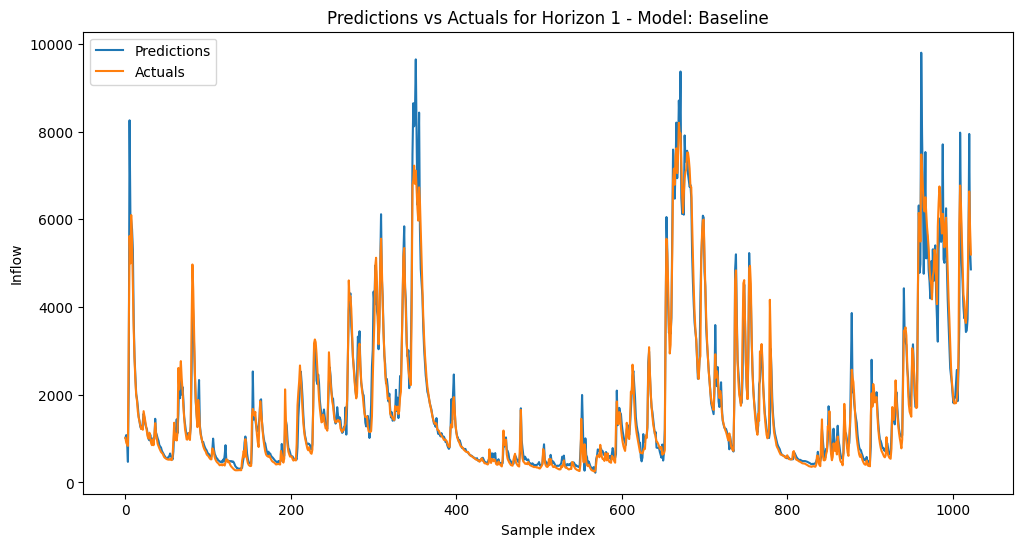

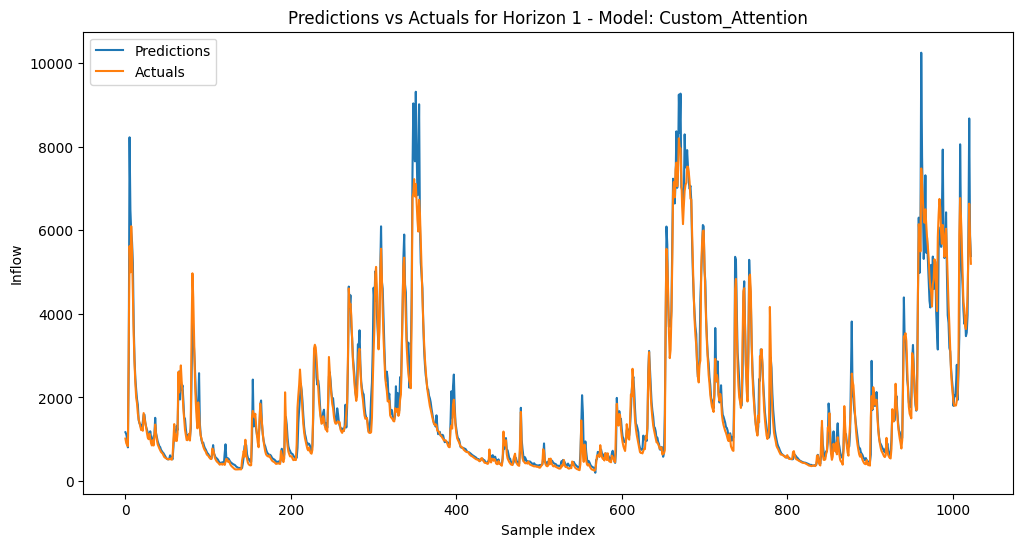

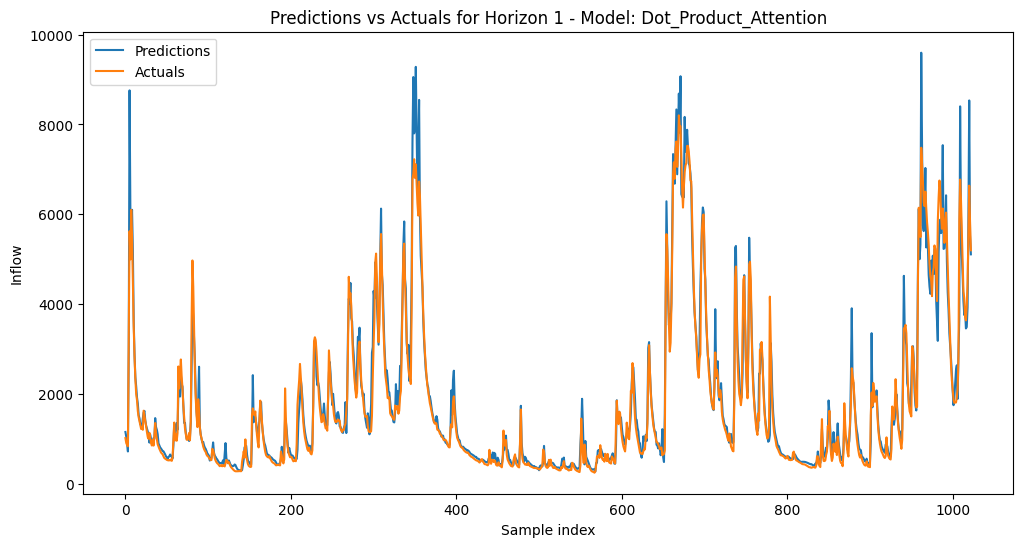

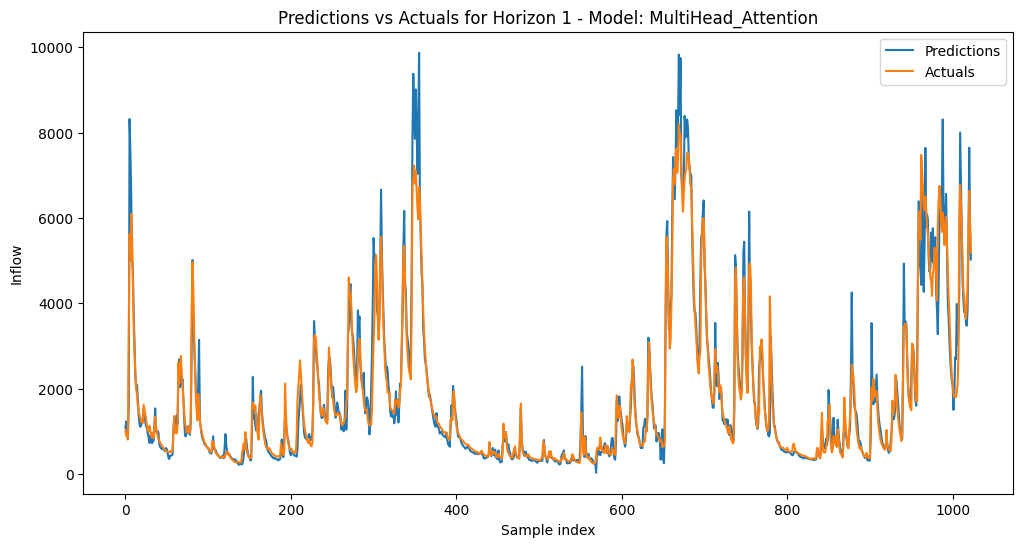

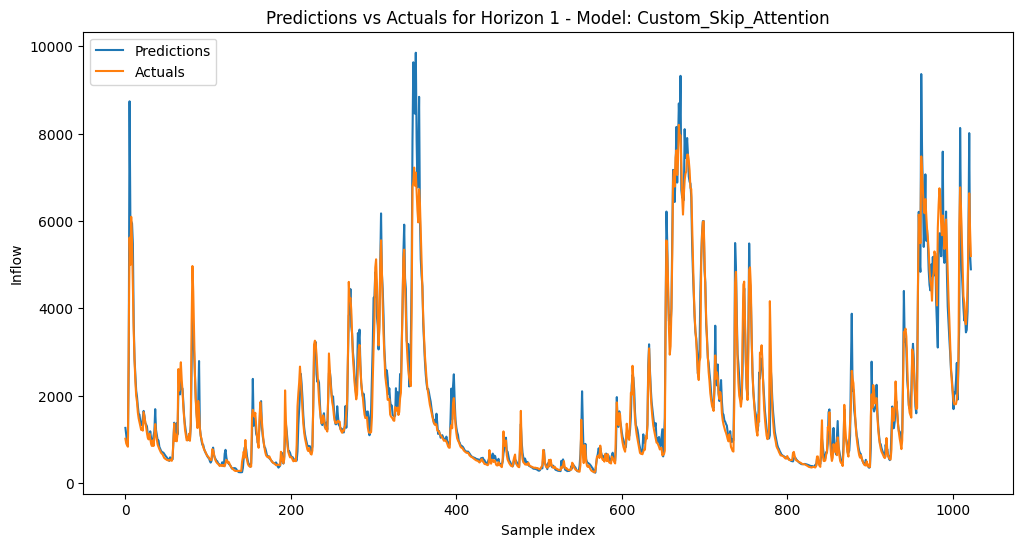

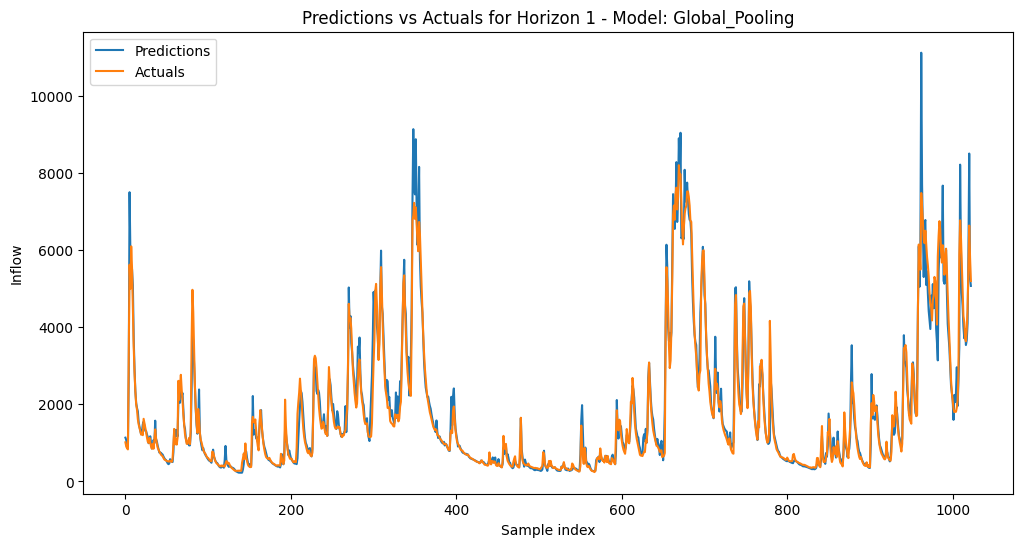

In [149]:
import matplotlib.pyplot as plt

# Loop over each model's predictions and plot them
for model_name, df_preds in predictions_dict.items():
    plt.figure(figsize=(12, 6))
    plt.plot(df_preds['Day 1 Pred'], label='Predictions')
    plt.plot(df_preds['Day 1 Actual'], label='Actuals')
    plt.xlabel('Sample index')
    plt.ylabel('Inflow')
    plt.title(f"Predictions vs Actuals for Horizon 1 - Model: {model_name}")
    plt.legend()
    plt.show()

ValueError: x and y must have same first dimension, but have shapes (1,) and (5,)

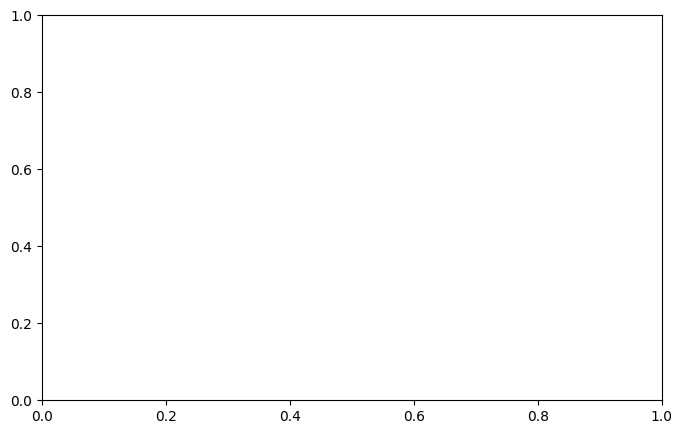

In [150]:
# Hard-coded RMSE values from R
rmse_yhat1 = [647.6976, 922.0222, 1126.1235, 1266.7477, 1356.4172]
rmse_yhatp = [559.0008, 893.0612, 1106.6746, 1248.3544, 1339.4242]

horizons = list(range(1,HORIZON+1))

# Plot each list with a line
plt.figure(figsize=(8, 5))
plt.plot(horizons, rmse_yhat1, marker='o', label='Yhat1')
plt.plot(horizons, rmse_yhatp, marker='o', label='YhatP')
plt.plot(horizons, rmse_values.values(), marker='o', label='LSTM')

plt.xlabel("Horizon k")
plt.ylabel("RMSE")
plt.title("RMSE for Each Forecast Horizon")
plt.legend()
plt.show()

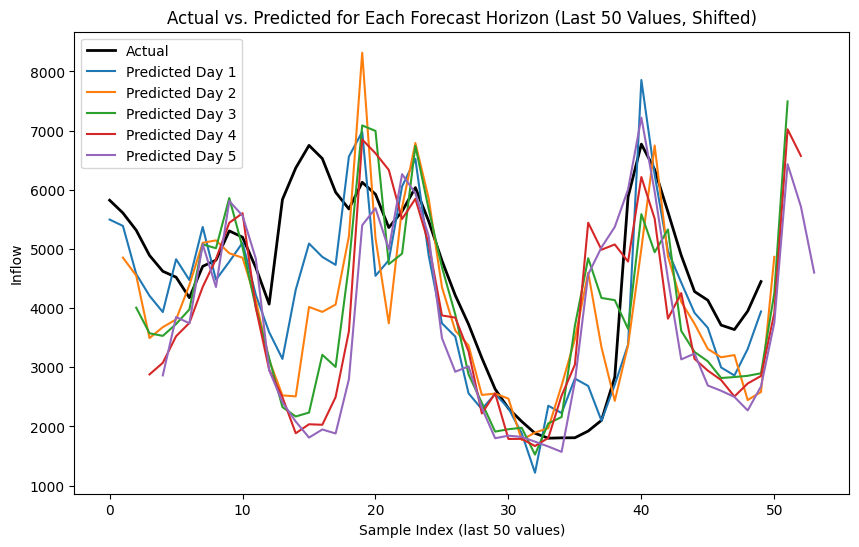

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_multi_horizon_single_actual_shifted(df, horizon=HORIZON, last_n=50):
    """
    Plots one actual line (since all horizons share the same actual values)
    and the predicted values for each forecast horizon on a single figure,
    using only the last 'last_n' samples, but SHIFTING each horizon's line
    so it aligns with the actual day it predicts.

    Assumes the DataFrame has:
      - An actual column named "Day 1 Actual"
      - Predicted columns for each horizon: "Day 1 Pred", "Day 2 Pred", ..., "Day k Pred"

    Parameters:
      df      : DataFrame with at least these columns
      horizon : Number of forecast days (e.g., 5)
      last_n  : How many of the final samples to plot
    """
    plt.figure(figsize=(10, 6))

    # We'll create an x-array for the "last_n" points
    # Day 1 predictions align at x, Day 2 at x+1, Day 3 at x+2, etc.
    x = np.arange(last_n)

    # Plot only the last 'last_n' samples of the actual values
    actual = df["Day 1 Actual"].tail(last_n).values
    plt.plot(x, actual, label="Actual", color="black", linewidth=2)

    # Plot each horizon with a horizontal shift of (i - 1)
    for i in range(1, horizon + 1):
        pred_col = f"Day {i} Pred"
        preds = df[pred_col].tail(last_n).values

        # Shift Day i's predictions by (i-1) steps
        x_shifted = x + (i - 1)
        plt.plot(x_shifted, preds, label=f"Predicted Day {i}")

    plt.xlabel(f"Sample Index (last {last_n} values)")
    plt.ylabel("Inflow")
    plt.title(f"Actual vs. Predicted for Each Forecast Horizon (Last {last_n} Values, Shifted)")
    plt.legend()
    plt.show()

# Example usage:
plot_multi_horizon_single_actual_shifted(post_processed_df, horizon=HORIZON, last_n=50)

